In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform

import matplotlib.pyplot as plt
from IPython import display


# 漢字識別 (pytorch)

支援python 版本: 3.5以上   
支援pytorch版本 : 1.2以上

雖然說手寫數字集Mnist是的深度學習界的Hello World，但是若將題目換成了中文，難度就有天壤之別，先不論中文字數量之龐大(unicode有兩萬多)，光是各個字的造字邏輯各異之外，各個朝代的字體變化之大，恐怕從小使用中文的我們都難以識別，這對於電腦來說當然還是一個超難的題目，沒錯，手寫漢字識別一直是到現在都還無解的一級難題。

![Alt text](../images/hanzi.jpg)

## 從錯誤率90幾%到正確率90幾%之路

這一個實作我给下的副標題是「從錯誤率90幾%到正確率90幾%之路」，這個中文字識別雖然只有100字，但是裡面各種字體收集得非常完整，從甲骨文金文小篆都有，字形種類多就算了，你會發現裡面包含的完整度與清晰度，甚至有很多像是從碑上拓印下來的，所以多呈現虛化、斷裂、歪斜等狀態，因此是個非常棘手的數據集。在這個Jupyter Notebook中我們首先使用Resnet50來處理他，但是這個號稱沒有不能收斂的Resnet模型似乎這踢上了鐵板，若是從空白模型訓練，跑上許久正確率仍舊停在不到5%，若是用預訓練模型，正確率大致上到30%左右也再也上不去了。  

教授機器學習或深度學習的課程很多，但很少帶大家來解決難題，以及思考解難題的思路。這其實是這是大陸一個數據競賽的考題，而我用同樣的數據曾經拿到測試集Top1正確率96.65%(大賽正規賽制是Top5正確率，給機率最高的5個類別，一個對了就算對)，排行第二名的成績。從錯誤率90幾%到正確率90幾%之路到底是如何練成的呢?我們在這次課程實作中會揭曉答案。  


我們首先簡單的來看一下基本的實作流程，首先引用所有需要的包，這次為了教學便利，我在pytorch, tensorflow, cntk上包裝了新的api「trident」，各位可以透過pip install tridentx --upgrade 來執行安裝。

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'

#!pip uninstall tridentx
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import densenet,resnet

trident 0.4.9
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.4.0.


trident這個的一大特色就是簡潔，數據集只要一行就能宣告完成，加入資料預處理流程也是非常簡單，只要把圖像處理函數都放入資料來源的.image_transform_funcs清單之中就好了。本系列課程有專屬的Data Provider，只需要利用load_examples_data('課程數據集代號')即可取得。

In [3]:
data_loader=T.load_examples_data('hanzi')
data_loader.image_transform_funcs=[
            to_rgb(),
            resize((128,128),True),
            normalize(0, 255),  
            normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
data_loader.minibatch_size=8

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
C:\Users\Allan\.trident\datasets\examples_hanzi\train
['且', '世', '东', '九', '亭', '今', '从', '令', '作', '使', '侯', '元', '光', '利', '印', '去', '受', '右', '司', '合', '名', '周', '命', '和', '唯', '堂', '士', '多', '夜', '奉', '女', '好', '始', '字', '孝', '守', '宗', '官', '定', '宜', '室', '家', '寒', '左', '常', '建', '徐', '御', '必', '思', '意', '我', '敬', '新', '易', '春', '更', '朝', '李', '来', '林', '正', '武', '氏', '永', '流', '海', '深', '清', '游', '父', '物', '玉', '用', '申', '白', '皇', '益', '福', '秋', '立', '章', '老', '臣', '良', '莫', '虎', '衣', '西', '起', '足', '身', '通', '遂', '重', '陵', '雨', '高', '黄', '鼎']
C:\Users\Allan\.trident\datasets\examples_hanzi\train/且/*.*g
400
C:\Users\Allan\.trident\datasets\examples_hanzi\train/世/*.*g
400
C:\Users\Allan\.trident\datasets\examples_hanzi\train/东/*.*g
400
C:\Users\Allan\.trident\datasets\examples_hanzi\train/九/*.*g
400
C:\Users\Allan\.trident\datasets\examples_hanzi\train/亭/*.*g
400
C:\User

C:\Users\Allan\.trident\datasets\examples_hanzi\test/和/*.*g
101
C:\Users\Allan\.trident\datasets\examples_hanzi\test/唯/*.*g
95
C:\Users\Allan\.trident\datasets\examples_hanzi\test/堂/*.*g
95
C:\Users\Allan\.trident\datasets\examples_hanzi\test/士/*.*g
97
C:\Users\Allan\.trident\datasets\examples_hanzi\test/多/*.*g
93
C:\Users\Allan\.trident\datasets\examples_hanzi\test/夜/*.*g
109
C:\Users\Allan\.trident\datasets\examples_hanzi\test/奉/*.*g
84
C:\Users\Allan\.trident\datasets\examples_hanzi\test/女/*.*g
81
C:\Users\Allan\.trident\datasets\examples_hanzi\test/好/*.*g
95
C:\Users\Allan\.trident\datasets\examples_hanzi\test/始/*.*g
124
C:\Users\Allan\.trident\datasets\examples_hanzi\test/字/*.*g
108
C:\Users\Allan\.trident\datasets\examples_hanzi\test/孝/*.*g
122
C:\Users\Allan\.trident\datasets\examples_hanzi\test/守/*.*g
86
C:\Users\Allan\.trident\datasets\examples_hanzi\test/宗/*.*g
89
C:\Users\Allan\.trident\datasets\examples_hanzi\test/官/*.*g
99
C:\Users\Allan\.trident\datasets\examples_hanzi\te

究竟是甚麼密技能讓正確率從超級低跳到96%?在此揭曉答案:   
(1)使用傳統機器視覺技術來處理圖片數據，把低品質的圖片的清晰程度提升   
(2)設計了較小型的Densenet從空白開始訓練。   

很多人學了深度學習之後，看到傳統的機器視覺技術就直接跳過，不想碰那些比較低階的舊技術，其實這是大錯特錯的。沒錯，在有了深度學習之後，似乎只要算力夠，網路結構夠複雜，任何問題就能迎刃而解。但是那只是機器快速找解的過程，但機器對事物的本質仍舊一無所知。像是這一題討論的是文字的圖像演進，但甚麼是「文字」機器其實是不了解的，更遑論去理解字型的歷史演進，加上圖像品質參差不齊，因此過多的雜訊會對於過度抽像的分類目標產生嚴重的干擾，因此我們需要透過傳統機器視覺技術，對於數據本身去做清洗，讓圖片數據本身更為清晰，雜訊可以有效的減少。

這次的圖像數據既然是文字，那意味著色彩不是這次的必要訊息(這也是為何預訓練模型沒法在這次發揮作用的主因，因為預訓練模型都是基於彩色圖片所訓練的)，使用二值化(binarization)技術可以明確的把圖像指派至0或1(在此我會乘上255，變成0或255)，但是若是使用固定的門檻值會有很大問題，因為有的圖片黑底白字有的則是白底灰字，甚至於還有灰色的，當然不能使用單一門檻值，因此我會使用自適應二值化技術，讓機器動態決定最佳的門檻值。我在這邊寫了一個簡單的測試程序，來看看二值化處理前後的效果。

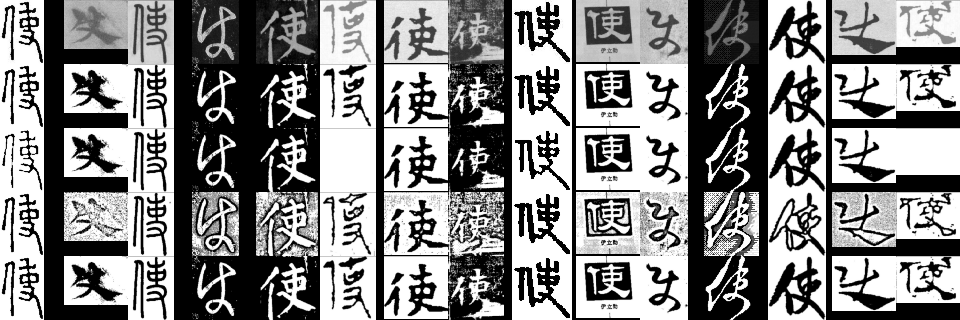

In [4]:
def test_image_binarization(*test_funcs, topk=15):
    result = data_loader.get_all_data(is_shuffle=False, topk=3800)[3780:3780+topk]#從原始數據中取15個字(我挑這個區段純粹是因為這段難度較高)
    
    resize_fn = resize((64, 64), True)
    before = []
    after = OrderedDict()
    after_img=[]
    for i in range(topk):
        fnc_result=[]
        #確保是灰階
        gray_result = gray_scale()(result[i]).astype(np.float32)
        fnc_result.append(resize_fn(gray_result.copy()))#取縮放至(64,64)
        for j in range(len(test_funcs)):#每一種二值化技術分別處理一次
            func=test_funcs[j]
            gray_result1=func(gray_result.copy())#自適應二值化處理
            fnc_result.append(resize_fn(gray_result1))#取縮放至(64,64)
        after_img.append(np.concatenate(fnc_result, axis=0))#把收集到的圖片沿y軸(axis=0)疊合
        
           
    merge = np.concatenate(after_img, axis=1) #把每個字的圖片沿x軸(axis=1)疊合

    return array2image(merge)

    
#測試的二值化技術清單
test_image_binarization(
adaptive_binarization('otsu'),
adaptive_binarization('minimum'),
adaptive_binarization('local'),
adaptive_binarization('isodata'))



從執行的結果看來，使用'otsu'或是'minimum'的效果是比較好的，local和isodata會有包覆的效果，但在本次分析來說並不是件好事。實際上，在trident中，adaptive_binarization的預設值正是otsu。



經過了二值化與對比調整，我們還是可以看到圖片上有不少雜斑，所以我們會需要把雜斑減少，此時圖像的腐蝕(erosion，讓黑色部分變大)與填充(dilation，讓白色部分變大)會是非常常見的處理手法。如果是黑底白字(且白字不會過細)，則進行先腐蝕後膨脹，如果是白底黑字(且黑字不會過細)，則是先膨脹後腐蝕。

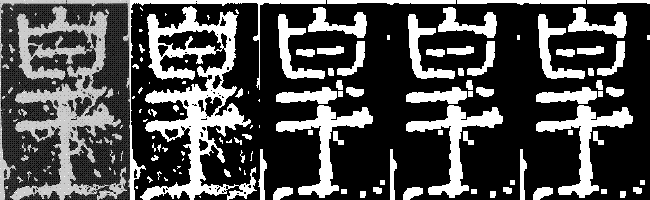

In [5]:
result=[]
#讀取圖片
im=image2array('../images/huang.jpg')
result.append(im.copy())
#自適應二值化
im=adaptive_binarization()(im)
result.append(im.copy())
#先腐蝕後膨脹
ed=erosion_then_dilation(filter_size=5,repeat=1)
for i in range(3):
    im=ed(im)
    result.append(im.copy())

im=np.concatenate(result,axis=-1)
array2image(im)

真實世界的數據絕對會比預想中的狀況更複雜，所以當進行數據清理時，視覺化絕對非常重要。而每次視覺化發現問題的地方，就可以回去調整預處理的流程，加入更嚴謹的判斷，或是針對一些特殊狀況加入新的處理流程。這邊課程實作為了方便教學並不會把處理流程搞得太複雜，但是我在這邊舉個例子大家就可以了解絕對部會是用一個標準流程套所有圖片。即使下圖是這麼刁鑽的題目(幾乎全黑，只有少部分白點)，我這邊自有辦法可以把它調整到可以合理清晰判讀的程度。

4.8375673 3.795545 15.077545


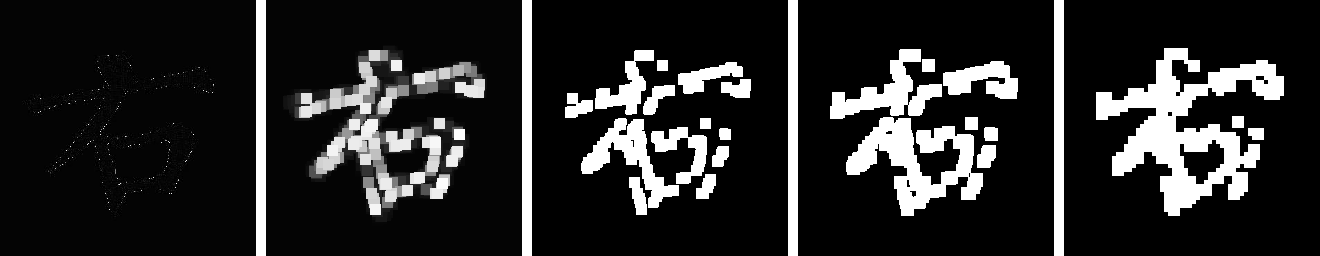

In [7]:
#原圖
img=resize((256, 256), True)(image2array('../images/yo.jpg'))
meanv=img.mean()
minv=img[img<meanv].mean()
maxv = img[img>meanv].mean()
print(meanv,minv,maxv)


#填充
img1= image_dilation(filter_size=3,repeat=5)(img)


#isodata二值化
img2=adaptive_binarization('otsu')(img1)
#將img2再填充
img3=image_dilation(filter_size=3,repeat=1)(img2)

#將img3縮小後進行otsu二值化後放大回原尺寸
img4=adjust_contrast(1.5)(resize((256, 256), True)(adaptive_binarization('otsu')(resize((64, 64), True)(img3))))

split=np.ones((img.shape[0],10))*255#圖片間的分隔空白
img=array2image(np.concatenate([img,split, img1,split,img2,split,img3,split,img4], axis=1))

img

在模型部分，我們可以做一個AB test，基準線是基於imagenet預訓練過的resnet50，至於另一個模型則是改成基於DenseNet結構所設計的骨幹，會比標準的DenseNet121小很多，因為不是標準模型所以沒有預訓練，使用隨機參數初始化。

Densely Connected Convolutional Networks
https://arxiv.org/pdf/1608.06993.pdf

DenseNet是ResNet的一種變種，與ResNet是一個單元內只會針對下一個區塊去做跳轉連接(skip connection)，而DenseNet則是在一個稱為DenseBlock的基本單位中，對「所有的下方區塊」都會跳轉連接。所以它可以很好緩解卷積神經網路在學習過程中，重要訊息被隨機丟失的問題。

![Alt text](../images/densenet.png)

In [8]:
resnet50=resnet.ResNet50(include_top=True,
             pretrained=True,
             input_shape=(3,128,128),
             classes=100)
resnet50.model.trainable=False
resnet50.model.fc.trainable=True
resnet50.model.layer4.trainable=True
resnet50.summary()

1364it [00:00, 1363773.70it/s]
0.00B [00:01, ?B/s]


model file is already existing, donnot need download again.
23712932 parameters have set untrainable
204900 parameters have set trainable
14964736 parameters have set trainable
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
first_block.conv                         [-1, 64, 112, 112]    [64, 3, 7, 7]                  9408      236015360.0 
first_block.norm                         [-1, 64, 112, 112]    [64]                 [64]      128       2395904.0   
first_block                              [-1, 64, 112, 112]                                   0         0.0         
maxpool                                  [-1, 64, 56, 56]                                     0         0.0         
layer1.0.branch1.0.conv                  [-1, 64, 56, 56]      [64, 64, 1, 1]                 4096      25686

In [9]:
densenet121 =densenet.DenseNet([5,8,10,6],16,32, include_top=True, pretrained=False,input_shape=(3,128,128), num_classes=100,name='densenet121')
#在輸出加入隨機噪音
densenet121.model.softmax.add_noise=True
densenet121.model.softmax.noise_intensity=0.5
densenet121.summary()


--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
conv1/conv.conv                          [-1, 32, 64, 64]      [32, 3, 7, 7]                  4704      38531072.0  
conv1/conv.norm                          [-1, 32, 64, 64]      [32]                 [32]      64        389120.0    
conv1/conv                               [-1, 32, 64, 64]                                     0         0.0         
maxpool                                  [-1, 32, 32, 32]                                     0         0.0         
denseblock1.denselayer1.norm             [-1, 32, 32, 32]      [32]                 [32]      64        97280.0     
denseblock1.denselayer1.relu             [-1, 32, 32, 32]                                     0         0.0         
denseblock1.denselayer1.conv1.conv       [-1, 64, 32

以下是我們這次實作所用的數據預處理組合，我真實比賽作的會再更複雜一些，有針對許多例外狀況做額外的補充處理，畢竟所有比賽都在計較那0.1%的提升，這個預處理組合其實成效也非常不錯了。

In [10]:
data_loader.image_transform_funcs=[
    random_invert_color(),
    random_center_crop(128,128,scale=(0.9,1.1))]

#隨機黑白翻轉
#隨機縮放取中心點切出128,128大小

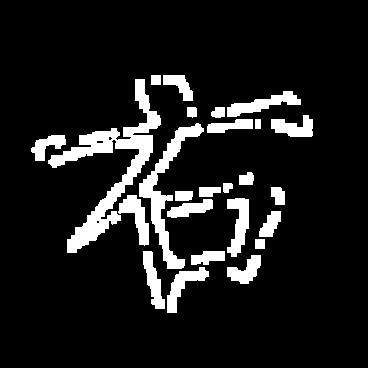

In [11]:
def noise_index(img):
    x1=img[1:,:]-img[:-1,:]
    x2=img[:,1:]-img[:,:-1]
    return (np.abs(x1).mean()+np.abs(x2).mean())/2

def is_white_background(img):
    p10=np.percentile(img,10)
    p90=np.percentile(img,90)
    if abs(p90-img.mean())<abs(p10-img.mean()) and p90-p10>80:
        return True
    elif abs(p90-img.mean())>abs(p10-img.mean()) and p90-p10>80:
        return False
    else:
        return None

policy1=PreprocessPolicy()



policy1.add(PreprocessPolicyItem(condition_if=lambda image: np.percentile(image,90)<40,then_process=[
                                                                                image_dilation(filter_size=3,repeat=3),
                                                                                downsample_then_upsample(scale=4,repeat=1),
                                                                                image_dilation(filter_size=3,repeat=1),
                                                                                adaptive_binarization('otsu')
                                                                                ]))

policy1.add(PreprocessPolicyItem(condition_if=lambda image:np.percentile(image,10)>200,then_process=[
                                                                                image_erosion(filter_size=3,repeat=3),
                                                                                downsample_then_upsample(scale=4,repeat=1),
                                                                                image_erosion(filter_size=3,repeat=1),
                                                                                adaptive_binarization('otsu')
                                                                                ]))
policy1.add(adaptive_binarization())
policy1.add(PreprocessPolicyItem(condition_if=lambda image:noise_index(image)>12 and is_white_background(image)==True,then_process=[
                                                                                dilation_then_erosion(filter_size=5,repeat=2)]))
policy1.add(PreprocessPolicyItem(condition_if=lambda image:noise_index(image)>12 and is_white_background(image)==False,then_process=[
                                                                                erosion_then_dilation(filter_size=5,repeat=2)]))


img=image2array('../images/yo.jpg')
img=policy1(img)
array2image(img)


雖然說我們剛剛的努力是在把數據清乾淨，但是在深度學習中，把數據搞髒來增加模型泛用程度的動作仍然是要的，但兩者有無衝突?其實不會，我們把數據清乾淨的目標是把會干擾到文字判讀的因子排除，至於把數據弄髒部分，由於為了要套用預處理模型，我們數據的輸入其實是rgb圖片而非是黑白圖片。為了避免未來有人輸入非黑白圖片文字造成模型無法識別，因此我們在此將透過隨機色相調整random_adjust_hue來搞髒數據。

In [12]:
policy1.add(to_rgb())
policy1.add(random_adjust_gamma(gamma=(0.8,1.2)))
policy1.add(random_adjust_hue())
policy1.add(random_blur())
policy1.add(add_noise(0.05))
policy1.add(normalize(127.5, 127.5)) 



policy0=PreprocessPolicy()
policy0.add(to_rgb())
policy0.add(random_adjust_gamma(gamma=(0.8,1.2)))
policy0.add(random_adjust_hue())
policy0.add(random_blur())
policy0.add(add_noise(0.05))
policy0.add(normalize(0, 255)) 
policy0.add(normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))



In [13]:
class DataProcessCallback(CallbackBase):
    def __init__(self, policy=None, **kwargs):
        super(DataProcessCallback, self).__init__()
        self.policy=policy
        
    def on_batch_start(self, training_context):
        try:
            train_data=training_context['train_data']
            test_data=training_context['test_data']
            
            input =train_data[train_data.key_list[0]]
            new_input = []
            for i in range(input.shape[0]):
                try:
                    new_input.append(self.policy(input[i]))
                except:
                    new_input.append(input[i])

            new_input = np.array(new_input).astype(np.float32)

            train_data[train_data.key_list[0]]= new_input
            
            if test_data is not None and len(test_data)>0:
                input =test_data[test_data.key_list[0]]
                new_input = []
                for i in range(input.shape[0]):
                    try:
                        new_input.append(self.policy(input[i]))
                    except:
                        new_input.append(input[i])

                new_input = np.array(new_input).astype(np.float32)

                test_data[test_data.key_list[0]]= new_input
        except Exception as e:
            print(e)


接著我們指定兩個模型對應的優化器、損失函數、評估函數，以及加入訓練時的權值約束與正規化。

In [14]:
resnet50=resnet50\
    .with_optimizer(optimizer='Adam',lr=2e-3,betas=(0.9, 0.999))\
    .with_loss(NullLoss)\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/hanzi_resnet50.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=1,cooldown=1,threshold=2e-4,warmup=0)\
    .with_callbacks(DataProcessCallback(policy0))\
    .with_callbacks(PrintGradientsCallback(batch_inteval=100))




NullLoss signature:[('output', [100]), ('target', [100])]
accuracy signature:[('output', [100]), ('target', [100])]
top3_accuracy signature:[('output', [100]), ('target', [100])]


在Denset的參數中唯一的差別是我將優化器換成了Ranger，來加速他收斂。

In [15]:
densenet121=densenet121\
    .with_optimizer(optimizer='Ranger',lr=2e-3,betas=(0.9, 0.999))\
    .with_loss(NullLoss)\
    .with_loss(F1ScoreLoss(num_class=100))\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(accuracy,topk=3,name='top3_accuracy')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/hanzi_densenet.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=1,cooldown=1,threshold=5e-4,warmup=0)\
    .with_callbacks(DataProcessCallback(policy1))\
    .with_callbacks(PrintGradientsCallback(batch_inteval=100))



Loading pretrained model from Models/hanzi_densenet.pth.tar
Missing keys:0
Unused checkpoint keys:0
Used keys:843
Model loaded!
NullLoss signature:[('output', [100]), ('target', [100])]
F1ScoreLoss signature:[('output', [100]), ('target', [100])]
accuracy signature:[('output', [100]), ('target', [100])]
top3_accuracy signature:[('output', [100]), ('target', [100])]


In [16]:
plan=TrainingPlan()\
    .add_training_item(resnet50,name='baseline')\
    .add_training_item(densenet121,name='challenger')\
    .with_data_loader(data_loader)\
    .repeat_epochs(6)\
    .within_minibatch_size(32)\
    .print_progress_scheduling(10,unit='batch')\
    .out_sample_evaluation_scheduling(50,'batch')\
    .display_loss_metric_curve_scheduling(frequency=50,unit='batch',imshow=True)\
    .save_model_scheduling(20,unit='batch')

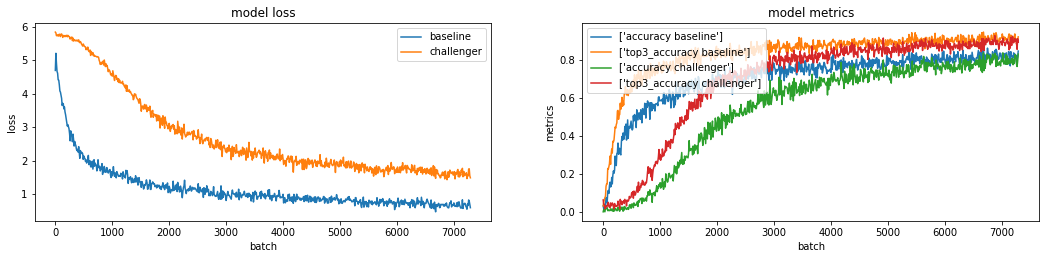

baseline     Step: 15s102ms | Loss: 0.711   | accuracy: 80.625% ,top3_accuracy: 91.250%  | learning rate: 2.000e-03 | epoch: 5  ( 1050/1250 )
out-of-sample evaluation:  accuracy: 56.250% ,top3_accuracy: 75.000% 
challenger   Step: 1s165ms  | Loss: 1.642   | accuracy: 79.688% ,top3_accuracy: 89.062%  | learning rate: 1.000e-03 | epoch: 5  ( 1050/1250 )
out-of-sample evaluation:  accuracy: 68.750% ,top3_accuracy: 87.500% 
baseline          first_layer gradients: 2.788e-04| last_layer gradients: 2.446e-04
challenger        first_layer gradients: 1.103e-02| last_layer gradients: 3.195e-03
baseline     Step: 12s338ms | Loss: 0.679   | accuracy: 78.750% ,top3_accuracy: 90.938%  | learning rate: 2.000e-03 | epoch: 5  ( 1060/1250 )
challenger   Step: 623ms    | Loss: 1.495   | accuracy: 82.187% ,top3_accuracy: 91.875%  | learning rate: 1.000e-03 | epoch: 5  ( 1060/1250 )
baseline     Step: 13s648ms | Loss: 0.761   | accuracy: 81.250% ,top3_accuracy: 90.312%  | learning rate: 2.000e-03 | epoch:

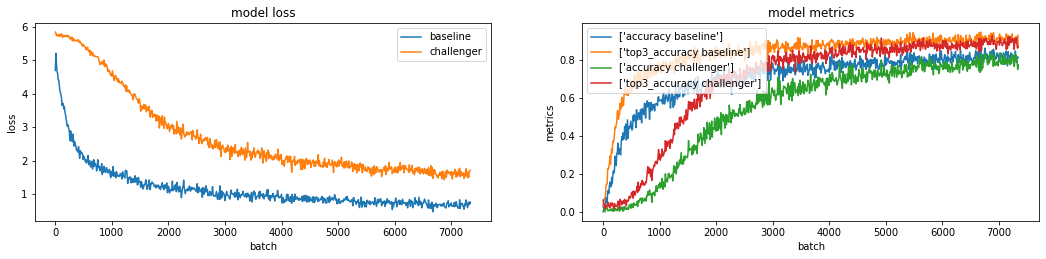

baseline     Step: 13s521ms | Loss: 0.843   | accuracy: 78.438% ,top3_accuracy: 89.375%  | learning rate: 2.000e-03 | epoch: 5  ( 1100/1250 )
out-of-sample evaluation:  accuracy: 81.250% ,top3_accuracy: 93.750% 
challenger   Step: 1s138ms  | Loss: 1.722   | accuracy: 78.750% ,top3_accuracy: 88.437%  | learning rate: 1.000e-03 | epoch: 5  ( 1100/1250 )
out-of-sample evaluation:  accuracy: 81.250% ,top3_accuracy: 84.375% 
baseline     Step: 14s131ms | Loss: 0.647   | accuracy: 82.812% ,top3_accuracy: 91.875%  | learning rate: 2.000e-03 | epoch: 5  ( 1110/1250 )
challenger   Step: 670ms    | Loss: 1.656   | accuracy: 77.188% ,top3_accuracy: 88.437%  | learning rate: 1.000e-03 | epoch: 5  ( 1110/1250 )
baseline     Step: 12s348ms | Loss: 0.638   | accuracy: 82.500% ,top3_accuracy: 92.500%  | learning rate: 2.000e-03 | epoch: 5  ( 1120/1250 )
challenger   Step: 578ms    | Loss: 1.560   | accuracy: 80.313% ,top3_accuracy: 90.312%  | learning rate: 1.000e-03 | epoch: 5  ( 1120/1250 )
baseline

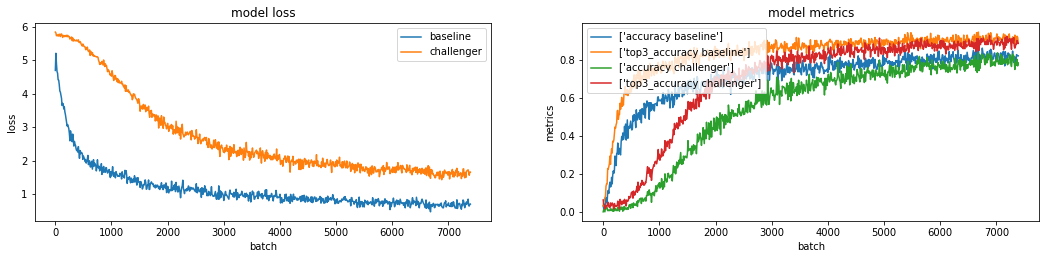

baseline     Step: 15s194ms | Loss: 0.775   | accuracy: 81.563% ,top3_accuracy: 89.375%  | learning rate: 2.000e-03 | epoch: 5  ( 1150/1250 )
out-of-sample evaluation:  accuracy: 62.500% ,top3_accuracy: 81.250% 
challenger   Step: 1s213ms  | Loss: 1.790   | accuracy: 75.625% ,top3_accuracy: 86.875%  | learning rate: 1.000e-03 | epoch: 5  ( 1150/1250 )
out-of-sample evaluation:  accuracy: 71.875% ,top3_accuracy: 81.250% 
baseline          first_layer gradients: 2.454e-04| last_layer gradients: 2.285e-04
challenger        first_layer gradients: 1.667e-02| last_layer gradients: 3.175e-03
baseline     Step: 12s404ms | Loss: 0.841   | accuracy: 80.625% ,top3_accuracy: 87.813%  | learning rate: 2.000e-03 | epoch: 5  ( 1160/1250 )
challenger   Step: 625ms    | Loss: 1.679   | accuracy: 79.375% ,top3_accuracy: 86.875%  | learning rate: 1.000e-03 | epoch: 5  ( 1160/1250 )
baseline     Step: 13s911ms | Loss: 0.781   | accuracy: 80.937% ,top3_accuracy: 89.688%  | learning rate: 2.000e-03 | epoch:

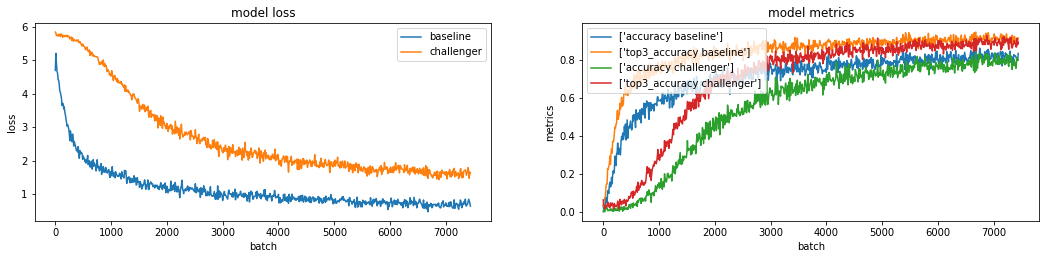

baseline     Step: 13s710ms | Loss: 0.719   | accuracy: 79.688% ,top3_accuracy: 90.000%  | learning rate: 2.000e-03 | epoch: 5  ( 1200/1250 )
out-of-sample evaluation:  accuracy: 75.000% ,top3_accuracy: 81.250% 
challenger   Step: 1s75ms   | Loss: 1.688   | accuracy: 76.562% ,top3_accuracy: 86.875%  | learning rate: 1.000e-03 | epoch: 5  ( 1200/1250 )
out-of-sample evaluation:  accuracy: 65.625% ,top3_accuracy: 84.375% 
baseline     Step: 13s751ms | Loss: 0.693   | accuracy: 82.812% ,top3_accuracy: 92.188%  | learning rate: 2.000e-03 | epoch: 5  ( 1210/1250 )
challenger   Step: 713ms    | Loss: 1.548   | accuracy: 80.625% ,top3_accuracy: 90.312%  | learning rate: 1.000e-03 | epoch: 5  ( 1210/1250 )
baseline     Step: 12s303ms | Loss: 0.622   | accuracy: 84.062% ,top3_accuracy: 93.437%  | learning rate: 2.000e-03 | epoch: 5  ( 1220/1250 )
challenger   Step: 551ms    | Loss: 1.522   | accuracy: 80.625% ,top3_accuracy: 91.562%  | learning rate: 1.000e-03 | epoch: 5  ( 1220/1250 )
baseline

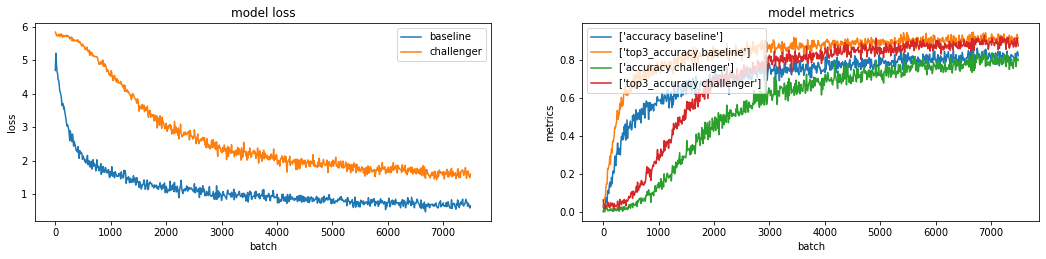

In [17]:
plan.start_now()


我們可以利用print_statistics來檢視剛才每個policy_item套用的案例比率

In [18]:
policy1.print_statistics()

policy item_0   hit-rate=2.177%
policy item_1   hit-rate=0.716%
policy item_3   hit-rate=8.102%
policy item_4   hit-rate=8.576%


In [17]:
#您也可以使用我這邊訓練過的預訓練模型
#densenet.load_model('Models/hanzi_densenet.pth.tar')


#記得要把類別代碼class_names設定完，我們才有辦法使用infer_single_image功能
#類別代碼可以直接從Data Provider取得

print(data_loader.class_names)
densenet121.class_names=data_loader.class_names['en-us']

{'en-us': ['且', '世', '东', '九', '亭', '今', '从', '令', '作', '使', '侯', '元', '光', '利', '印', '去', '受', '右', '司', '合', '名', '周', '命', '和', '唯', '堂', '士', '多', '夜', '奉', '女', '好', '始', '字', '孝', '守', '宗', '官', '定', '宜', '室', '家', '寒', '左', '常', '建', '徐', '御', '必', '思', '意', '我', '敬', '新', '易', '春', '更', '朝', '李', '来', '林', '正', '武', '氏', '永', '流', '海', '深', '清', '游', '父', '物', '玉', '用', '申', '白', '皇', '益', '福', '秋', '立', '章', '老', '臣', '良', '莫', '虎', '衣', '西', '起', '足', '身', '通', '遂', '重', '陵', '雨', '高', '黄', '鼎'], 'zh-cn': ['且', '世', '东', '九', '亭', '今', '从', '令', '作', '使', '侯', '元', '光', '利', '印', '去', '受', '右', '司', '合', '名', '周', '命', '和', '唯', '堂', '士', '多', '夜', '奉', '女', '好', '始', '字', '孝', '守', '宗', '官', '定', '宜', '室', '家', '寒', '左', '常', '建', '徐', '御', '必', '思', '意', '我', '敬', '新', '易', '春', '更', '朝', '李', '来', '林', '正', '武', '氏', '永', '流', '海', '深', '清', '游', '父', '物', '玉', '用', '申', '白', '皇', '益', '福', '秋', '立', '章', '老', '臣', '良', '莫', '虎', '衣', '西', '起', '足', '身', '通', '遂', '重', '陵'

In [18]:
#使用infer_single_image兩個要件
#第一個是要設定正確的分類代碼class_names
#第二個是要在preprocess_flow清單中列出圖片送去推論前的所有處理步驟
#由於目前是要做推論而非建模，因此需要調整一下內容
#就不需要隨機的數據增強

densenet121.preprocess_flow=[
    PreprocessPolicyItem(condition_if=lambda image: np.percentile(image,90)<40,then_process=[
                                                                                image_dilation(filter_size=3,repeat=3),
                                                                                downsample_then_upsample(scale=4,repeat=1),
                                                                                image_dilation(filter_size=3,repeat=1),
                                                                                adaptive_binarization('otsu')
                                                                                ]),
    PreprocessPolicyItem(condition_if=lambda image:np.percentile(image,10)>200,then_process=[
                                                                                image_erosion(filter_size=3,repeat=3),
                                                                                downsample_then_upsample(scale=4,repeat=1),
                                                                                image_erosion(filter_size=3,repeat=1),
                                                                                adaptive_binarization('otsu')
                                                                                ]),
    adaptive_binarization(),
    PreprocessPolicyItem(condition_if=lambda image:noise_index(image)>12 and is_white_background(image)==True,then_process=[
                                                                                dilation_then_erosion(filter_size=5,repeat=2)]),
    PreprocessPolicyItem(condition_if=lambda image:noise_index(image)>12 and is_white_background(image)==False,then_process=[
                                                                                erosion_then_dilation(filter_size=5,repeat=2)]),
    to_rgb(),
    resize((128,128),True),
    normalize(127.5, 127.5)]
#自適應二值化
#Clahe
#腐蝕/填充
#自動色階
#再做一次自適應二值化
#轉RGB
#依照原比例縮放至128

接下來由於我們需要測試一下模型效果，因此需要使用測試集數據(測試集數據與訓練集是完全獨立的)，在trident的data provider中可以透過直接存取traindata或是testdata來切換訓練集或是測試集，兩者都是獨立的Iterator，所以也擁有各自的batch_sampler。   
   
下面我們就將透過next_test()，一次取回一個batch的測試集數據，透過densenet121.infer_single_image進行評分預測，然後比對模型預測的前3名答案與實際答案是否一致?

預測:OrderedDict([('新', (53, 0.99955684)), ('朝', (57, 0.000220222)), ('永', (64, 0.00010200355))])  答案:新
預測:OrderedDict([('新', (53, 0.9957942)), ('和', (23, 0.0018223167)), ('秋', (79, 0.0008883757))])  答案:新
預測:OrderedDict([('光', (12, 0.9955374)), ('令', (7, 0.0025890328)), ('常', (44, 0.0008961314))])  答案:光
預測:OrderedDict([('东', (2, 0.9918566)), ('来', (59, 0.008064348)), ('奉', (29, 3.134898e-05))])  答案:东
預測:OrderedDict([('老', (82, 0.89268726)), ('世', (1, 0.040506516)), ('去', (15, 0.03575105))])  答案:老
預測:OrderedDict([('思', (49, 0.99772996)), ('西', (88, 0.0007406378)), ('始', (32, 0.0005240077))])  答案:思
預測:OrderedDict([('多', (27, 0.99961275)), ('易', (54, 0.0001967878)), ('立', (80, 0.00011011417))])  答案:多
預測:OrderedDict([('印', (14, 0.9465797)), ('易', (54, 0.02753764)), ('氏', (63, 0.00436436))])  答案:印


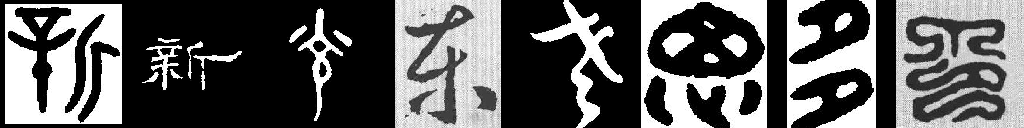

In [21]:
resize_fn=resize((128,128),True)

data,label=data_loader.next_test()
results=[]
imgs=[]
for i in range(8):
    results.append('預測:{0}  答案:{1}'.format(densenet121.infer_single_image(data[i].copy(),3),densenet121.class_names[label[i]]))
    imgs.append(resize_fn(data[i]))

for item in results:
    print(item)
array2image(np.concatenate(imgs,axis=-1))